<a href="https://colab.research.google.com/github/smartgeometry-ucl/COMP0169-2021-CourseWorks/blob/master/CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 1: Learning Learning, From Scratch
_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Luca Morreale, Pradyumna Reddy, Sanjeev Muralikrishnan & Animesh Karnewar__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission:

Coursework submissions must comprise of this **single** jupyter notebook, containing your code and written comments. Cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any way. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#begin_solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated.

Please, do not change `#begin_test ... #end_test` blocks.

Each exercise must be implemented from scratch. Unless differently specified, only numpy and matplotlib are allowed. The libraries are imported in [the package cell](#packages) and cannot be modified.

Note: The `optimize` module from `scipy` can only be used for the question where it is specified, and not anywhere else.



**Questions:**

[Question 1](#question1): Linear Fitting (10 points)

[Question 2](#question2): Free form optimization (18 points)

[Question 3](#question3): Clustering (14 points)

[Question 4](#question4): Linear Classification (18 points)

[Question 5](#question5): Non-linear Classification (20 points)

[Question 6](#question6): Neural Networks (20 points)

## Datasets

We will be using two datasets for the whole coursework: _IRIS_ and _MNIST_. Both datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits. The features of each image are the pixels themselves.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

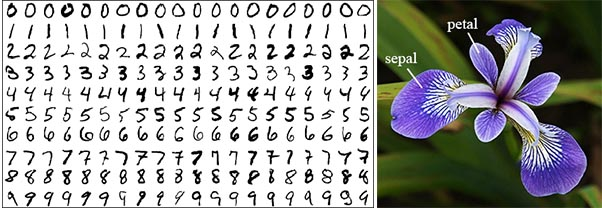

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [29]:
# Importing packages
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn import decomposition
from sklearn.model_selection import train_test_split

%matplotlib inline

In [30]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)



## Data Loading

The following cells are used to load both datasets, _Iris_ and _MNIST_.

In [31]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [9]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [41]:
def plot_dataset(X, Y, dims=[0,1]):
    # Keep only two dimensions
    X_reduced = X[:, dims]
    # Plot the data points
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Feat 1')
    plt.ylabel('Feat 2')
    plt.show()

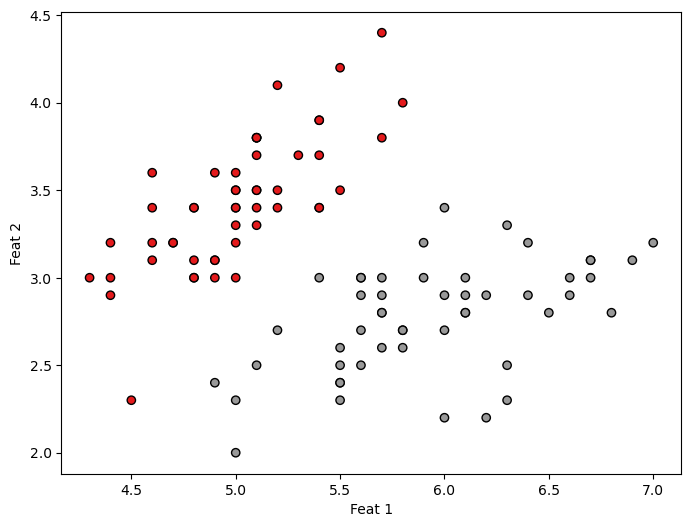

In [42]:
X,Y=load_iris_dataset()
dataset=X,Y
plot_dataset(X,Y)

In [43]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()


In [44]:
def plot_eigenvecs(stacked_images, n_rows, n_columns):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]))
        plt.axis('off')
    plt.show()

def plot_grey_image(stacked_images, n_rows, n_columns, titles):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if len(titles) == n_rows*n_columns:
          plt.title(titles[i])
    plt.show()

In [45]:
def plot_loss_curve(logs):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(logs)
    plt.show()

In [46]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [32]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test
print("X:",X.shape,"Y",Y.shape)
X_iris = X_iris.reshape(540,1)
# X_iris
# x_train=np.arange(0,len(X),1)
# y_iris = np.arrange(0,len(Y),1)

X: (150, 4) Y (150,)


_MNIST_ dataset

In [33]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**Question 1.a**
<a name='question1a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [63]:
def nsolve(X,y):
    X = np.c_[[1,1,1],[1,2,3]] # defining features
    y = np.c_[[1,3,2]] # defining labels

    w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) # normal equation



    #begin_solution

    #end_solution
    return w
nsolve(0,1)

Testing your code on mockup data.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [64]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#begin_solution
def nsolve(X,y):
    X = np.c_[[1,1,1],[1,2,3]] # defining features
    y = np.c_[[1,3,2]] # defining labels

    w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) # normal equation

#end_solution
    return w

**Question 1.b**
<a name='question1b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [14]:
class LinearRegression() :

    def __init__( self, learning_rate, iterations ) :

        self.learning_rate = learning_rate

        self.iterations = iterations



    def fit( self, X, Y ) :

        # no_of_training_examples, no_of_features

        self.m, self.n = X.shape

        # weight initialization

        self.W = np.zeros( self.n )

        self.b = 0

        self.X = X

        self.Y = Y
                # gradient descent learning

        for i in range( self.iterations ) :

            self.update_weights()

        return self
            # Helper function to update weights in gradient descent

    def update_weights( self ) :

        Y_pred = self.predict( self.X )

        # calculate gradients

        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.m

        db = - 2 * np.sum( self.Y - Y_pred ) / self.m

        # update weights

        self.W = self.W - self.learning_rate * dW

        self.b = self.b - self.learning_rate * db

        return self
            # Hypothetical function  h( x )

    def predict( self, X ) :

        return X.dot( self.W ) + self.b


def update_weights_MSE(m, b, X, Y, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        m_deriv += -2*X[i] * (Y[i] - (m*X[i] + b))

        # -2(y - (mx + b))
        b_deriv += -2*(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate

    return m, b

Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [16]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#begin_solution

def update_weights_MSE(m, b, X_iris, Y_iris, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        m_deriv += -2*X[i] * (Y[i] - (m*X[i] + b))

        # -2(y - (mx + b))
        b_deriv += -2*(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate
    print("l2 loss:",X_iris-m[0])

    return m, b


#end_solution
update_weights_MSE(1,0,1,2,0.001)


'\nAfter implementing line_fit, test it below on IRIS Test set.\nPrint the L2 error with respect to Test set.\n'

In [ ]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#begin_solution
def update_weights_MSE(m, b, X_iris_test, Y_iris_test, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        m_deriv += -2*X[i] * (Y[i] - (m*X[i] + b))

        # -2(y - (mx + b))
        b_deriv += -2*(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate
    print("l2 error: ",Y_iris_test-b[0])

    return m, b

#end_solution

Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [17]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#begin_solution
from matplotlib import pyplot as plt
plt.plot(X_iris_test,Y_iris_test)

#end_solution

'\nBelow, plot and display the correlation between true y and predicted values.\n'

**Question 1.c**
<a name='question1c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [28]:
def __init__(self, d=5):# fucntion to define degree
    self.d = d

    def poly_fit(X,y):
        A = []
        C = []
        for i in range(self.d):
            A_row = []
            for j in range(self.d):
                A_row.append(np.sum([x**(i+j) for x in X]))
            A.append(A_row)
            C.append(np.sum(np.multiply([x**i for x in X], y)))
        w = np.linalg.inv(A) * np.transpose(C)
        self.w = w
        print("L2 Error:",w)
        return w
    
    
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """

    #begin_solution
def __init__(self, d=5):# fucntion to define degree
    self.d = d

    def poly_fit(X,y):
        A = []
        C = []
        for i in range(self.d):
            A_row = []
            for j in range(self.d):
                A_row.append(np.sum([x**(i+j) for x in X]))
            A.append(A_row)
            C.append(np.sum(np.multiply([x**i for x in X], y)))
        w = np.linalg.inv(A) * np.transpose(C)
        self.w = w
        print("L2 Error:",w)
        return w

    #end_solution
#Write your implementation of poly_fit here?




Testing your code on _IRIS_.

In [ ]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#begin_solution
def update_weights_MSE(m, b, X_iris, Y_iris, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        m_deriv += -2*X[i] * (Y[i] - (m*X[i] + b))

        # -2(y - (mx + b))
        b_deriv += -2*(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate
    print ("L2 loss",Y_iris-b[0])

    return m, b
update_weights_MSE(1,2,2,2,0.01)

#end_solution

In [ ]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#begin_solution
def update_weights_MSE(m, b, X_iris_test, Y_iris_test, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        m_deriv += -2*X[i] * (Y[i] - (m*X[i] + b))

        # -2(y - (mx + b))
        b_deriv += -2*(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate
    print ("L2 loss",Y_iris_test-m[0])
   

    return m, b

#end_solution


In [ ]:
update_weights_MSE(1,0,1,2,0.001)

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Showing the correlation between X and y.

In [ ]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#begin_solution
def update_weights_MSE(m, b, X_iris_test, Y_iris_test, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        m_deriv += -2*X[i] * (Y[i] - (m*X[i] + b))

        # -2(y - (mx + b))
        b_deriv += -2*(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate
    print ("L2 loss",Y_iris_test-m[0])
    from matplotlib import pyplot as plt
    plt.plot(b,m)

    return m, b

#end_solution
update_weights_MSE(1,0,1,2,0.001)


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

## 2. Free form optimization (18 points)
<a name='question2'></a>

[a)](#question2a) Implement Gradient Descent (GD) (**3 points**), Gradient Descent with Nesterov Momentum (GDN)  (**4 points**) and a second order optimization method (**4 points**)

[b)](#question2b) Write the gradient and hessian of "paraboloid" and run the optimization methods on it (**7 points** on hidden test)

**Question 2.a**
<a name='question2a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change=1.0e-6):
    """
    Write your own implementation of gradient descent here.
    
    Arguments:
    
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
from numpy import asarray
from numpy import arange
from numpy.random import rand
from matplotlib import pyplot
    
    #begin_solution
def objective(x):
	return x**2.0
 
# derivative of objective function
def derivative(x):
	return x * 2.0
 
# gradient descent algorithm
def gradient_descent(objective, derivative, bounds, n_iter, step_size):
	# track all solutions
	solutions, scores = list(), list()
	# generate an initial point
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# run the gradient descent
	for i in range(n_iter):
		# calculate gradient
		gradient = derivative(solution)
		# take a step
		solution = solution - step_size * gradient
		# evaluate candidate point
		solution_eval = objective(solution)
		# store solution
		solutions.append(solution)
		scores.append(solution_eval)
		# report progress
		print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
	return [solutions, scores]

# define range for input
bounds = asarray([[-1.0, 1.0]])
# define the total iterations
n_iter = 30
# define the step size
step_size = 0.1
# perform the gradient descent search
solutions, scores = gradient_descent(objective, derivative, bounds, n_iter, step_size)
# sample input range uniformly at 0.1 increments
inputs = arange(bounds[0,0], bounds[0,1]+0.1, 0.1)
# compute targets
results = objective(inputs)

    #end_solution

        
   
    
    

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [66]:
    #begin_solution
def objective(x, y):
	return x**2.0 + y**2.0
 
# derivative of objective function
def derivative(x, y):
	return asarray([x * 2.0, y * 2.0])
 
# gradient descent algorithm with nesterov momentum
def nesterov(objective, derivative, bounds, n_iter, step_size, momentum):
	# track all solutions
	solutions = list()
	# generate an initial point
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# list of changes made to each variable
	change = [0.0 for _ in range(bounds.shape[0])]
	# run the gradient descent
	for it in range(n_iter):
		# calculate the projected solution
		projected = [solution[i] + momentum * change[i] for i in range(solution.shape[0])]
		# calculate the gradient for the projection
		gradient = derivative(projected[0], projected[1])
		# build a solution one variable at a time
		new_solution = list()
		for i in range(solution.shape[0]):
			# calculate the change
			change[i] = (momentum * change[i]) - step_size * gradient[i]
			# calculate the new position in this variable
			value = solution[i] + change[i]
			# store this variable
			new_solution.append(value)
		# store the new solution
		solution = asarray(new_solution)
		solutions.append(solution)
		# evaluate candidate point
		solution_eval = objective(solution[0], solution[1])
		# report progress
		print('>%d f(%s) = %.5f' % (it, solution, solution_eval))
	return solutions
from numpy.random import seed
# seed the pseudo random number generator
seed(1)
# define range for input
bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
# define the total iterations
n_iter = 50
# define the step size
step_size = 0.01
# define momentum
momentum = 0.8
# perform the gradient descent search with nesterov momentum
solutions = nesterov(objective, derivative, bounds, n_iter, step_size, momentum)

    #end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
    #begin_solution
import numpy as np

def hw(w0, w1, x):
    final = w0 + w1*x
    return final

def error(x,y,w0,w1):
    return y - hw(w0, w1 ,x)

def sumError(training_points, w0, w1):
    sum = 0
    for i in training_points:
        sum += error(i[0], i[1], w0, w1)
    return sum

def sumError2(training_points, w0, w1):
    sum = 0
    for i in training_points:
        sum += error(i[0], i[1], w0, w1) * i[0]
    return sum

def updateW0(training_points, w0 , w1, learning_rate):
    final = w0 + learning_rate * sumError(training_points, w0, w1)
    final = np.round(final,round)
    return final

def updateW1(training_points, w0, w1, learning_rate):
    final = w1 + learning_rate * sumError2(training_points, w0, w1)
    final = np.round(final,round)
    return final

def update_iteration(number_of_iterations, training_points, w0, w1, learning_rate):
    print("----Batch Gradient Descend----")
    w0_new = 0
    w1_new = 0
    for i in range(number_of_iterations):
        w0_new = updateW0(training_points, w0, w1, learning_rate)
        w1_new =updateW1(training_points, w0, w1, learning_rate)

        print("--------------------------------")
        print(f"iteration {i+1}: w0 = {w0_new}")
        print(f"iteration {i+1}: w1 = {w1_new}")
        w0 = w0_new
        w1 = w1_new
    print("================================")
    return w0_new, w1_new
  
# round 3 decimal points
round = 3 
    
training_points = [
    (1.5, 1),
    (3.5, 3),
    (3,2),
    (5,3),
    (2,2.5),
]

w0 = 0
w1 = 0
learning_rate = 0.01
number_of_iterations = 3

update_iteration(number_of_iterations,training_points,w0, w1,learning_rate)

    #end_solution


In [ ]:
def square(X):
    return np.power(X, 2).sum()

def d_square(X):
    return 2 * X

def dd_square(X):
    hessian = np.eye(X.shape[0]) * 2
    return hessian

**Question 2.b**
<a name='question2b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def paraboloid(X): # paraboloid or saddle function X[0]^2-X[1]^2+X[2]^2 ... 
    tmp = np.power(X, 2)
    return tmp[0::2].sum() - tmp[1::2].sum()

def d_paraboloid(X):
    gradient = np.zeros(X.shape[0])
    #begin_solution
    return np.sum(X**2)
    

    #end_solution

    return gradient

def dd_paraboloid(X):
    hessian = np.eye(X.shape[0])
    #begin_solution
    return X[0]**2 + X[1]**3

    #end_solution

    return hessian
dd_paraboloid(X)

In [ ]:
#begin_test
def partial(element, function):
    
    partial_diff = function.diff(element)

    return partial_diff


def gradient(partials):

    grad = numpy.matrix([[partials[0]], [partials[1]]])

    return grad
def gradient_to_zero(symbols_list, partials):

    partial_x = Eq(partials[0], 0)
    partial_y = Eq(partials[1], 0)

    singular = solve((partial_x, partial_y), (symbols_list[0], symbols_list[1]))

    return singular
def hessian(partials_second, cross_derivatives):

    hessianmat = numpy.matrix([[partials_second[0], cross_derivatives], [cross_derivatives, partials_second[1]]])

    return hessianmat
import numpy
from sympy import symbols, Eq, solve, log  
def main():

        x, y = symbols('x y')
        symbols_list = [x, y]
        function = x**2 - (3/2)*x*y + y**2
        partials, partials_second = [], []

        for element in symbols_list:
            partial_diff = partial(element, function)
            partials.append(partial_diff)

        grad = gradient(partials)
        singular = gradient_to_zero(symbols_list, partials)

        cross_derivatives = partial(symbols_list[0], partials[1])

        for i in range(0, len(symbols_list)):
            partial_diff = partial(symbols_list[i], partials[i])
            partials_second.append(partial_diff)

        hessianmat = hessian(partials_second, cross_derivatives)
        #det = determat(partials_second, cross_derivatives, singular, symbols_list)

        print("Hessian matrix that organizes all the second partial derivatives of the function {0} is :\n {1}".format(function, hessianmat))
        #print("Determinant in the singular point {0} is :\n {1}".format(singular, det))

main()

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#parameters     = np.ones(1)
#objective      = square
#d_objective    = d_square
#step_size      = 0.1
#max_iterations = 100
#eps_change     = 1.0e-6
#parameter are defined at the end


#begin_test
from numpy import asarray
from numpy import arange
from numpy.random import rand
from matplotlib import pyplot
    
    #begin_solution
def objective(x):
	return x**2.0
 
# derivative of objective function
def derivative(x):
	return x * 2.0
 
# gradient descent algorithm
def gradient_descent(objective, derivative, bounds, n_iter, step_size):
	# track all solutions
	solutions, scores = list(), list()
	# generate an initial point
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# run the gradient descent
	for i in range(n_iter):
		# calculate gradient
		gradient = derivative(solution)
		# take a step
		solution = solution - step_size * gradient
		# evaluate candidate point
		solution_eval = objective(solution)
		# store solution
		solutions.append(solution)
		scores.append(solution_eval)
		# report progress
		print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
	return [solutions, scores]

# define range for input
bounds = asarray([[-1.0, 1.0]])
# define the total iterations
n_iter = 100
# define the step size
step_size = 0.1
# perform the gradient descent search
solutions, scores = gradient_descent(objective, derivative, bounds, n_iter, step_size)
# sample input range uniformly at 0.1 increments
inputs = arange(bounds[0,0], bounds[0,1]+0.1, 0.1)
# compute targets
results = objective(inputs)

#end_test


#parameters     = np.ones(1)
#objective      = square
#d_objective    = d_square
#momentum       = 0.4
#step_size      = 0.1
#max_iterations = 100
#eps_change     = 1.0e-6


#begin_test
def objective(x, y):
	return x**2.0 + y**2.0
 
# derivative of objective function
def derivative(x, y):
	return asarray([x * 2.0, y * 2.0])
 
# gradient descent algorithm with nesterov momentum
def nesterov(objective, derivative, bounds, n_iter, step_size, momentum):
	# track all solutions
	solutions = list()
	# generate an initial point
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# list of changes made to each variable
	change = [0.0 for _ in range(bounds.shape[0])]
	# run the gradient descent
	for it in range(n_iter):
		# calculate the projected solution
		projected = [solution[i] + momentum * change[i] for i in range(solution.shape[0])]
		# calculate the gradient for the projection
		gradient = derivative(projected[0], projected[1])
		# build a solution one variable at a time
		new_solution = list()
		for i in range(solution.shape[0]):
			# calculate the change
			change[i] = (momentum * change[i]) - step_size * gradient[i]
			# calculate the new position in this variable
			value = solution[i] + change[i]
			# store this variable
			new_solution.append(value)
		# store the new solution
		solution = asarray(new_solution)
		solutions.append(solution)
		# evaluate candidate point
		solution_eval = objective(solution[0], solution[1])
		# report progress
		print('>%d f(%s) = %.5f' % (it, solution, solution_eval))
	return solutions
from numpy.random import seed
# seed the pseudo random number generator
seed(1)
# define range for input
bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
# define the total iterations
n_iter = 50
# define the step size
step_size = 0.01
# define momentum
momentum = 0.8
# perform the gradient descent search with nesterov momentum
solutions = nesterov(objective, derivative, bounds, n_iter, step_size, momentum)


#end_test


#parameters     = np.ones(1)
#objective      = square
#d_objective    = d_square
#dd_objective   = dd_square
#step_size      = 1.0
#max_iterations = 200
#eps_change     = 1.0e-6



#begin_test
def hw(w0, w1, x):
    final = w0 + w1*x
    return final

def error(x,y,w0,w1):
    return y - hw(w0, w1 ,x)

def sumError(training_points, w0, w1):
    sum = 0
    for i in training_points:
        sum += error(i[0], i[1], w0, w1)
    return sum

def sumError2(training_points, w0, w1):
    sum = 0
    for i in training_points:
        sum += error(i[0], i[1], w0, w1) * i[0]
    return sum

def updateW0(training_points, w0 , w1, learning_rate):
    final = w0 + learning_rate * sumError(training_points, w0, w1)
    final = np.round(final,round)
    return final

def updateW1(training_points, w0, w1, learning_rate):
    final = w1 + learning_rate * sumError2(training_points, w0, w1)
    final = np.round(final,round)
    return final

def update_iteration(number_of_iterations, training_points, w0, w1, learning_rate):
    print("----Batch Gradient Descend----")
    w0_new = 0
    w1_new = 0
    for i in range(number_of_iterations):
        w0_new = updateW0(training_points, w0, w1, learning_rate)
        w1_new =updateW1(training_points, w0, w1, learning_rate)

        print("--------------------------------")
        print(f"iteration {i+1}: w0 = {w0_new}")
        print(f"iteration {i+1}: w1 = {w1_new}")
        w0 = w0_new
        w1 = w1_new
    print("================================")
    return w0_new, w1_new
  
# round 3 decimal points
round = 3 
    
training_points = [
    (1.5, 1),
    (3.5, 3),
    (3,2),
    (5,3),
    (2,2.5),
]

w0 = 0
w1 = 0
learning_rate = 0.01
number_of_iterations = 3

update_iteration(number_of_iterations,training_points,w0, w1,learning_rate)


#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_test
def paraboloid(X): # paraboloid or saddle function X[0]^2-X[1]^2+X[2]^2 ... 
    tmp = np.power(X, 2)
    return tmp[0::2].sum() - tmp[1::2].sum()

def d_paraboloid(X):
    gradient = np.zeros(X.shape[0])
    #begin_solution
    return np.sum(X**2)
    

    #end_solution

    return gradient

def dd_paraboloid(X):
    hessian = np.eye(X.shape[0])
    #begin_solution
    return X[0]**2 + X[1]**3

    #end_solution

    return hessian

#end_test
def grad(paraboliod,d_paraboloid,dd_paraboloid):
    return grad

grad(1,0,0.1)


## 3. Clustering (14 points)
<a name='question3'></a>

[a)](#question3a) Implement a function pca(X, ndims) that performs PCA over the input data X and returns both the mean vector  ̄X and the ndims top components. The top components are the eigen vectors linked to the top eigen values computed from the covariance matrix. Try your function on the _MNIST_ dataset, which is composed of 10 digit classes. Display the top 10 components fitted on the train dataset as images. Next, check that you can reconstruct perfectly an input digit from the test set using all components, by implementing pca_projection(X, mean_vec, eig_vecs) and pca_reconstruction(weights, mean_vec, eig_vecs). (**3 points** + **4 points** on hidden dataset)

[b)](#question3b) Perform independent research on the clustering algorithm k-means. Implement a function kmeans performing k-means on input data X. Propose the interface to that function (i.e., what is its input and output?) and write in three sentences why this is. Apply you kmeans implementation on the _MNIST_ training set with k= 10 clusters and display the centroids as images. (**2 points** + **3 points** on hidden dataset)

[c)](#question3c) Describe the k-means algorithm, highlighting similarities and differences from PCA. Compare the reconstruction loss on the validation set for both k-means and PCA. Write no more than ten sentences. (**2 points**)

**Question 3.a**
<a name='question3a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def pca(X, ndims):
    """
    Write your implementation of PCA here.

    Arguments:
    X : Data matrix
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #begin_solution
    #Step-1
    mean_vec = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(mean_vec , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:ndims]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , mean_vec.transpose() ).transpose()
     
#     return X_reduced

    #end_solution


    return mean_vec, eigen_vectors
# print(pca(X,1))


Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [11]:
"""
Below, test your PCA on  MNIST dataset.
Plot and display the selected eigen vectors returned by PCA.
"""

#begin_solution
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test
#end_solution

In [20]:
#begin_test
def pca(X_mnist_test, ndims):
    """
    Write your implementation of PCA here.

    Arguments:
    X : Data matrix
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #begin_solution
    #Step-1
    mean_vec = X_mnist_test - np.mean(X_mnist_test , axis = 0)
     
    #Step-2
    cov_mat = np.cov(mean_vec , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:ndims]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , mean_vec.transpose() ).transpose()
     
#     return X_reduced

    #end_solution


    return mean_vec, eigen_vectors



#end_test
pca(X_mnist_test,1)



(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

Now, we can evaluate if the code is working properly by projecting the first image of the test set on the eigen vectors.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [51]:
import numpy as np
def pca(X, n_dim):
  means = np.mean(X, axis=0)
  X = X - means
  square_m = np.dot(X.T, X)
  (evals, evecs) = np.linalg.eig(square_m)
  result = np.dot(X, evecs[:,0:n_dim])
  return result

x_data = np.array([
[0.3750, 0.3750, 0.6250, 0.5000, 1.0000, 0.1250],
[0.5000, 1.0000, 0.3125, 0.6875, 1.0000, 0.0000],
[0.9375, 0.7500, 0.8125, 0.1250, 1.0000, 0.7500],
[0.4375, 0.6875, 0.5000, 0.4375, 1.0000, 0.1875],
[0.6875, 0.7500, 0.4375, 0.3750, 1.0000, 0.0625],
[0.5625, 0.6250, 0.5625, 0.2500, 0.9375, 0.0000],
[0.5625, 0.8125, 0.1875, 0.5000, 0.7500, 0.0000],
[0.9375, 0.5000, 0.8125, 0.2500, 1.0000, 0.2500],
[0.7500, 0.5625, 0.8125, 0.3750, 0.8125, 0.0625],
[0.9375, 0.5000, 0.7500, 0.3125, 1.0000, 0.1875]],
 dtype=np.float32)

print("\nBegin PCA demo ")
np.set_printoptions(precision=4, suppress=True)
print("\nSource data: ")
print(x_data)

pca_2 = decomposition.PCA(2)
pca_2.fit(x_data)
x_reduced = pca_2.transform(x_data)
print("\nComponents from scikit PCA() function: ")
print(x_reduced)
print("\nPercent variance explained via scikit: ")
ve = pca_2.explained_variance_ratio_
print(ve)

x_reduced = pca(x_data, 2)
print("\nComponents from custom pca() function: ")
print(x_reduced)

# compute percent variance explained
x_transform = pca(x_data, 6)  # all columns
v = np.var(x_transform, axis=0, ddof=1)
sv = np.sum(v)
ve = np.array([v[0] / sv, v[1] / sv])
print("\nPercent variance explained computed: ")
print(ve)

print("\nEnd demo ")


Begin PCA demo 

Source data: 
[[0.375  0.375  0.625  0.5    1.     0.125 ]
 [0.5    1.     0.3125 0.6875 1.     0.    ]
 [0.9375 0.75   0.8125 0.125  1.     0.75  ]
 [0.4375 0.6875 0.5    0.4375 1.     0.1875]
 [0.6875 0.75   0.4375 0.375  1.     0.0625]
 [0.5625 0.625  0.5625 0.25   0.9375 0.    ]
 [0.5625 0.8125 0.1875 0.5    0.75   0.    ]
 [0.9375 0.5    0.8125 0.25   1.     0.25  ]
 [0.75   0.5625 0.8125 0.375  0.8125 0.0625]
 [0.9375 0.5    0.75   0.3125 1.     0.1875]]

Components from scikit PCA() function: 
[[-0.1089 -0.3185]
 [-0.5097  0.2176]
 [ 0.625   0.3629]
 [-0.1712  0.0079]
 [-0.1368  0.0754]
 [-0.0845 -0.1206]
 [-0.4504  0.1383]
 [ 0.3954 -0.0828]
 [ 0.1349 -0.1853]
 [ 0.3062 -0.0949]]

Percent variance explained via scikit: 
[0.619  0.1927]

Components from custom pca() function: 
[[-0.1089  0.3185]
 [-0.5097 -0.2176]
 [ 0.625  -0.3629]
 [-0.1712 -0.0079]
 [-0.1368 -0.0754]
 [-0.0845  0.1206]
 [-0.4504 -0.1383]
 [ 0.3954  0.0828]
 [ 0.1349  0.1853]
 [ 0.3062  0.094


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [34]:
def reconstruction(X, n, trans):
    """
    Creates a reconstruction of an input record, X, using the topmost (n) vectors from the
    given transformation (trans)

    Note 1: In this dataset each record is the set of pixels in the image (flattened to
    one row).
    Note 2: X should be normalized before input.
    """
    vectors = [trans.components_[n] * X[n] for n in range(0, n)]

    # Invert the PCA transformation.
    ret = trans.inverse_transform(X)

    # This process results in non-normal noise on the margins of the data.
    # We clip the results to fit in the [0, 1] interval.
    ret[ret < 0] = 0
    ret[ret > 1] = 1
    return ret

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

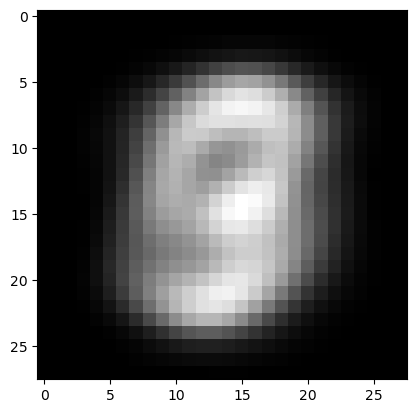

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


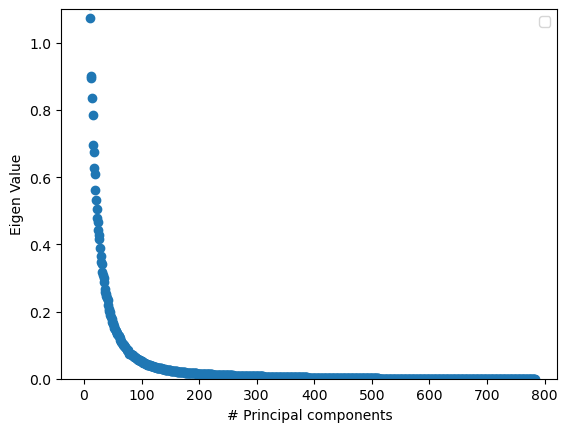

<Figure size 640x480 with 0 Axes>

[(0, 's'), (1, 'x'), (2, 'o'), (3, '.'), (4, ','), (5, '<'), (6, '>'), (7, '^'), (8, '8'), (9, '*')]


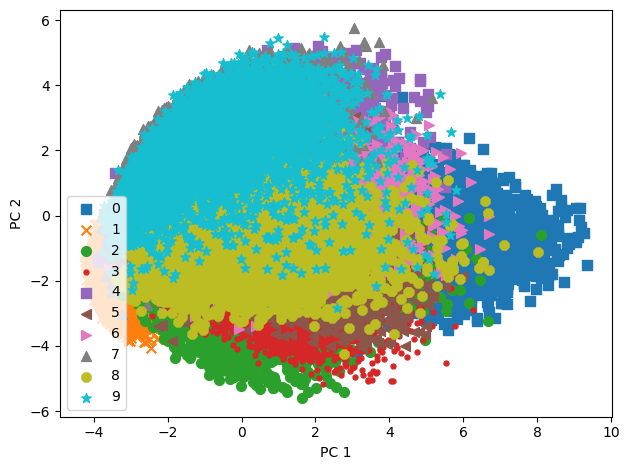

<Figure size 640x480 with 0 Axes>

(784, 5)


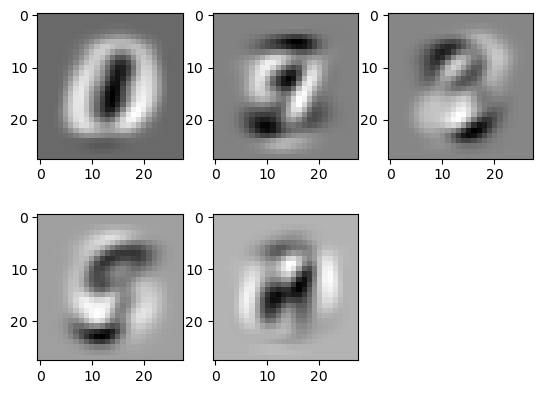

In [72]:
"""
Below, 
1. Perform  PCA on MNIST training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the 
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution
mean = np.mean(X, axis = 0)
mean_img = np.array(mean).reshape(28,28)
plt.imshow(mean_img, cmap='gray')
plt.show()
X_std = (X - mean)
cov_mat = np.cov(X_std, rowvar = 0)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eigen_values_sorted = np.argsort(-eig_vals)
plt.ylabel('Eigen Value')
plt.xlabel('# Principal components')
plt.ylim(0, 1.1)
plt.legend(loc = 'best')
plt.scatter(range(eig_vals.shape[0]),eig_vals[eigen_values_sorted])
plt.figure()
plt.tight_layout()
plt.show()
def plot_mnist_pca(X_pca, y):
    markers = 's','x','o','.',',','<','>', '^','8','*'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    print(list(zip(target,markers)))
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,c = colors[idx]['color'], label = t, marker = m)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.figure()
    plt.show()
X_std_pca = X_std.dot(eig_vecs[:,eigen_values_sorted[:2]])
plot_mnist_pca(X_std_pca, Y)
print(eig_vecs[:,eigen_values_sorted[:5]].shape)
for i in range(5):
    reshape = eig_vecs[:,eigen_values_sorted[i]].reshape(28,28)
    plt.subplot(2,3,i+1)
    plt.imshow(reshape.real, cmap = "gray")
#end_solution


**Question 3.b**
<a name='question3b'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

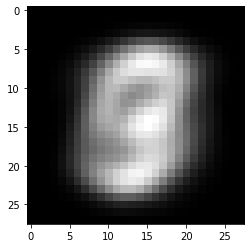

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\talha\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


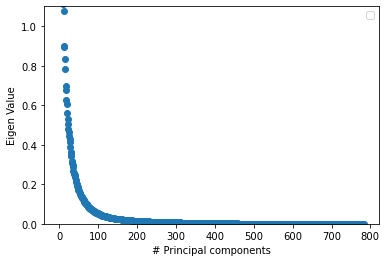

<Figure size 432x288 with 0 Axes>

[(0, 's'), (1, 'x'), (2, 'o'), (3, '.'), (4, ','), (5, '<'), (6, '>'), (7, '^'), (8, '8'), (9, '*')]


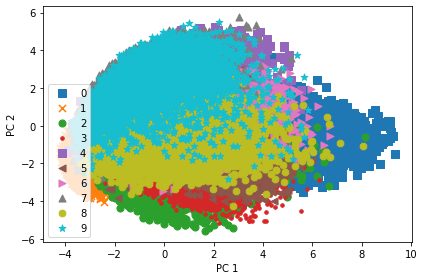

<Figure size 432x288 with 0 Axes>

(784, 5)


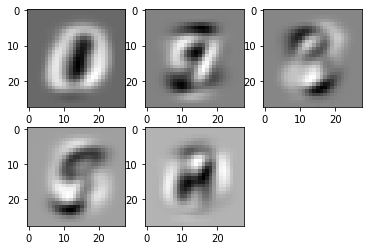

In [21]:
#begin_test
mean = np.mean(X_mnist_test, axis = 0)
mean_img = np.array(mean).reshape(28,28)
plt.imshow(mean_img, cmap='gray')
plt.show()
X_std = (X - mean)
cov_mat = np.cov(X_std, rowvar = 0)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eigen_values_sorted = np.argsort(-eig_vals)
plt.ylabel('Eigen Value')
plt.xlabel('# Principal components')
plt.ylim(0, 1.1)
plt.legend(loc = 'best')
plt.scatter(range(eig_vals.shape[0]),eig_vals[eigen_values_sorted])
plt.figure()
plt.tight_layout()
plt.show()
def plot_mnist_pca(X_pca, y):
    markers = 's','x','o','.',',','<','>', '^','8','*'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    print(list(zip(target,markers)))
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,c = colors[idx]['color'], label = t, marker = m)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.figure()
    plt.show()
X_std_pca = X_std.dot(eig_vecs[:,eigen_values_sorted[:2]])
plot_mnist_pca(X_std_pca, Y)
print(eig_vecs[:,eigen_values_sorted[:5]].shape)
for i in range(5):
    reshape = eig_vecs[:,eigen_values_sorted[i]].reshape(28,28)
    plt.subplot(2,3,i+1)
    plt.imshow(reshape.real, cmap = "gray")

#end_test


In [52]:
#Importing required modules
 
import numpy as np
from scipy.spatial.distance import cdist 
 
#Function to implement steps given in previous section
def kmeans(x,k, no_of_iterations=1000):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'euclidean') #Step 2
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
#     This is list of centroids
        centroids = np.vstack(centroids) #Updated Centroids 
         
#         distances = cdist(x, centroids ,'euclidean')
#         points = np.array([np.argmin(i) for i in distances])
         
    return centroids
kmeans(X,3)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
def recalculate_clusters(X, centroids, k):
    """ Recalculates the clusters """
    # Initiate empty clusters
    clusters = {}
    # Set the range for value of k (number of centroids)
    for i in range(k):
        clusters[i] = []
    for data in X:
        euc_dist = []
        for j in range(k):
            euc_dist.append(np.linalg.norm(data - centroids[j]))
        # Append the cluster of data to the dictionary
        clusters[euc_dist.index(min(euc_dist))].append(data)
    return clusters
def recalculate_centroids(centroids, clusters, k):
    """ Recalculates the centroid position based on the plot """
    for i in range(k):
        centroids[i] = np.average(clusters[i], axis=0)
        plt.plot(centroids[i])
        plt.show()
    return centroids

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

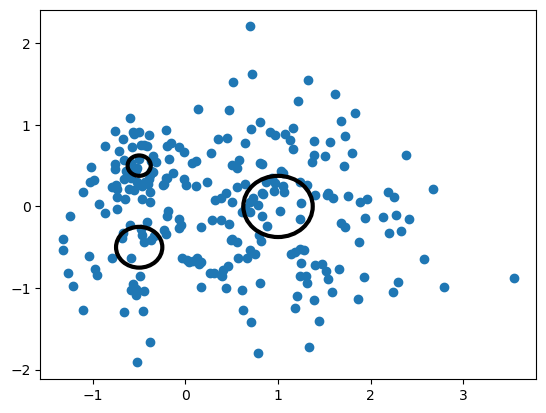

In [66]:
"""
Below, test your kmeans on the MNIST dataset.
For all 10 digits, plot and display the cluster centroids as an image grid. 
Use provided plotting functions.
"""

#begin_solution
points = np.vstack(((np.random.randn(150, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(50, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(50, 2) * 0.5 + np.array([-0.5, -0.5]))))
def initialize_centroids(points, k):
    """returns k centroids from the initial points"""
    centroids = points.copy()
    np.random.shuffle(centroids)

    return centroids[:k]
initialize_centroids(points, 10)
plt.scatter(points[:, 0], points[:, 1])
ax = plt.gca()
ax.add_artist(plt.Circle(np.array([1, 0]), 0.75/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, 0.5]), 0.25/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, -0.5]), 0.5/2, fill=False, lw=3))
#end_solution


**Question 3.c**
<a name='question3c'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

In [ ]:
#begin_test

#end_test


## 4. Linear Classification (18 points)
<a name='question4'></a>

[a)](#question4a) Implement the normal equation-based binary linear classifier lclass(examplesA, examplesB, testExamples) where the first two arguments are the set of samples from class A and class B respectively and the third is the test. The function should return a vector of 0s and 1s, 0 if test is in A and 1 otherwise. It should, for simplicity, both train and test in one function call. (**3 points**)
Test this on all the samples in _IRIS_, Setosa vs non-Setosa, etc and propose a simple analysis (text, figure, table) of the result you find, but not longer than ten sentences. (**4 points** on hidden dataset)

[b)](#question4b) Perform independent research how to do multi-class classification. Implement lclass_prob(examplesA, examplesB, testExamples) and lmclass(examples, class, testExamples) that together perform multi-class classification of the examples examples according to the vector of labels class of the same size and test it with testExamples by returning a matrix, where each row expresses the probability of a sample in testExamples to belong to each class. Give the accuracy of your model. (**5 points** + **6 points** on hidden dataset)
Present findings applying multi-class classification on _IRIS_ dataset with 3 classes. You can include figures and tables if needed. Write no longer than ten sentences.

**Question 4.a**
<a name='question4a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lclass(examplesA, examplesB, testExample):
    """
    Write your implementation of normal equation based linear classifier here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted 0/1 labels on testExample
    """

    #begin_solution

    #end_solution


    return preds

_IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing lclass, test it below on the IRIS dataset.
"""

#begin_solution

#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Below, plot and display the confusion matrix of your prediction with respect to 
true values. Use provided functions for plotting.
"""

#begin_solution

#end_solution


In [ ]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

**Question 4b**
<a name='question4b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:

  """
  Write your implementation of the softmax activation here.

  Arguments:
  preds : The output predicted classes from your classifier

  Returns:
  activation : The outputs after applying softmax activation
  """

  #begin_solution
def softmax(z):
    
    
    # z--> linear part.
    
    # subtracting the max of z for numerical stability.
    exp = np.exp(z - np.max(z))
    
    # Calculating softmax for all examples.
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
        
    return exp

  #end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
    #begin_solution
def fit(X, y, lr, c, epochs):
    
    # X --> Input.
    # y --> true/target value.
    # lr --> Learning rate.
    # c --> Number of classes.
    # epochs --> Number of iterations.
    
        
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape
    
    # Initializing weights and bias randomly.
    w = np.random.random((n, c))
    b = np.random.random(c)    # Empty list to store losses.
    losses = []
    
    # Training loop.
    for epoch in range(epochs):
        
        # Calculating hypothesis/prediction.
        z = X@w + b
        y_hat = softmax(z)
        
        # One-hot encoding y.
        y_hot = one_hot(y, c)
        
        # Calculating the gradient of loss w.r.t w and b.
        w_grad = (1/m)*np.dot(X.T, (y_hat - y_hot)) 
        b_grad = (1/m)*np.sum(y_hat - y_hot)
        
        # Updating the parameters.
        w = w - lr*w_grad
        b = b - lr*b_grad
        
        # Calculating loss and appending it in the list.
        loss = -np.mean(np.log(y_hat[np.arange(len(y)), y]))
        losses.append(loss)        # Printing out the loss at every 100th iteration.
        if epoch%100==0:
            print('Epoch {epoch}==> Loss = {loss}'
                  .format(epoch=epoch, loss=loss)) 
            return w, b, losses
    
    
    
    

    #end_solution
w, b, l = fit(X_iris, Y_iris,lr=0.9, c=10, epochs=1000)


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
    #begin_solution
    def predict(X, w, b):
    
    # X --> Input.
    # w --> weights.
    # b --> bias.
    
    # Predicting
        z = X@w + b
        y_hat = softmax(z)
    
    # Returning the class with highest probability.
        return np.argmax(y_hat, axis=1)
    

    #end_solution

    
    return preds_prob

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

In [ ]:
#begin_test
def softmax(z):
    
    
    # z--> linear part.
    
    # subtracting the max of z for numerical stability.
    exp = np.exp(z - np.max(z))
    
    # Calculating softmax for all examples.
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
        
    return exp
#y_hat = softmax(w.X + b)
#loss = -np.mean(np.log(y_hat[np.arange(len(y)), y]))

def fit(X, y, lr, c, epochs):
    
    # X --> Input.
    # y --> true/target value.
    # lr --> Learning rate.
    # c --> Number of classes.
    # epochs --> Number of iterations.
    
        
    # m-> number of Testing examples
    # n-> number of features 
    m, n = X.shape
    
    # Initializing weights and bias randomly.
    w = np.random.random((n, c))
    b = np.random.random(c)    # Empty list to store losses.
    losses = []
    
    # Testing loop.
    for epoch in range(epochs):
        
        # Calculating hypothesis/prediction.
        z = X@w + b
        y_hat = softmax(z)
        
        # One-hot encoding y.
        y_hot = one_hot(y, c)
        
        # Calculating the gradient of loss w.r.t w and b.
        w_grad = (1/m)*np.dot(X.T, (y_hat - y_hot)) 
        b_grad = (1/m)*np.sum(y_hat - y_hot)
        
        # Updating the parameters.
        w = w - lr*w_grad
        b = b - lr*b_grad
        
        # Calculating loss and appending it in the list.
        loss = -np.mean(np.log(y_hat[np.arange(len(y)), y]))
        losses.append(loss)        # Printing out the loss at every 100th iteration.
        if epoch%100==0:
            print('Epoch {epoch}==> Loss = {loss}'
                  .format(epoch=epoch, loss=loss)) 
            return w, b, losses
        def accuracy(y, y_hat):
            return np.sum(y==y_hat)/len(y)
train_preds = predict(X_iris, w, b)
accuracy(Y_iris, train_preds)


#end_test


## 5. Non-linear Classification (20 points)
<a name='question5'></a>

[a)](#question5a) Implement classification based on logistic regression using GD by implementing the gradient function dlogistic(preds, X, Y) and optimizing using GD. preds are the prediction from the model, X are the data and Y are the labels. Propose a function interface for your implementation of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[b)](#question5b) Implement classification based on hinge loss using GD by implementing the gradient function dhinge(preds,
W, X, Y) and optimizing using GD. preds are the prediction from the model, W describes the model parameters, X is the data and Y represent the labels. Propose a function interface for your implementation
of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[c)](#question5c) Implement kernel SVM function ksvm(kernel, X, Y, X_test). The function takes as input a kernel function kernel, training data X, Y and a set of test points X_test. The function returns the set of support vectors along with the predicted labels. You are allowed to use scipy optimization library to solve the quadratic problem of SVM. (**5 points** + **7 points** on hidden dataset)

**Question 5.a**
<a name='question5a'></a>

In [22]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1 + np.exp(-z))
    ### END CODE HERE ###

    return s
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)                                     # compute activation
    cost = -1./m* np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))                                  # compute cost
    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1./m*np.dot(X, (A-Y).T)
    db = 1./m*np.sum(A-Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    #cost = np.squeeze(cost)
    #assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))
#End solution

sigmoid([0, 2]) = [0.5        0.88079708]
w = [[0.]
 [0.]]
b = 0
dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


Implementation of the sigmoid activation function and Logistic Regression.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [23]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

        costs = []

        for i in range(num_iterations):


            # Cost and gradient calculation (≈ 1-4 lines of code)
            ### START CODE HERE ###
            grads, cost =propagate(w, b, X, Y)
            ### END CODE HERE ###

            # Retrieve derivatives from grads
            dw = grads["dw"]
            db = grads["db"]

            # update rule (≈ 2 lines of code)
            ### START CODE HERE ###

            w = w - learning_rate * dw
            b = b - learning_rate * db
            ### END CODE HERE ###

            # Record the costs
            if i % 100 == 0:
                costs.append(cost)

            # Print the cost every 100 training examples
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))

        params = {"w": w,
                  "b": b}

        grads = {"dw": dw,
                 "db": db}

        return params, grads, costs

params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


In [24]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    global s
    s = 1/(1 + np.exp(-z))
    ### END CODE HERE ###

    return s

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A =   sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
             Y_prediction[0, i] = 0
        ### END CODE HERE ###

    assert(Y_prediction.shape == (1, m))

    return Y_prediction
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


Implementation of the loss function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [25]:
def logistic_loss(preds, targets):
    """
    Implement your logistic loss function here.

    Arguments:
    preds : Predicted values
    targets : Target values

    Returns :
    cost : The mean logistic loss value between preds and targets
    """

    #begin_solution
    cost =  (-targets * np.log(preds) - (1 - targets) * np.log(1 - preds)).mean()

    #end_solution


    return cost
cost

6.000064773192205

Implementation of the gradient

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [39]:
def dlogistic(preds, X, Y,W=[]):
    """
    Implement the derivative of the logistic loss here.

    Arguments:
    preds : Predicted values
    X : Input data matrix
    Y : True target values
    W : The weights, optional argument, may/may not be needed depending on the loss function
    """

    #begin_solution
    w= ((1 - X) / (1 - Y) - X / Y) / np.size(X)

    #end_solution

    
    return w
w

array([[1],
       [2]])

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [40]:
"""
After implementing logistic_loss, dlogistic and gd, test it below using the IRIS dataset.
"""

#begin_test
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

        costs = []

        for i in range(num_iterations):


            # Cost and gradient calculation (≈ 1-4 lines of code)
            ### START CODE HERE ###
            grads, cost =propagate(w, b, X, Y)
            ### END CODE HERE ###

            # Retrieve derivatives from grads
            dw = grads["dw"]
            db = grads["db"]

            # update rule (≈ 2 lines of code)
            ### START CODE HERE ###

            w = w - learning_rate * dw
            b = b - learning_rate * db
            ### END CODE HERE ###

            # Record the costs
            if i % 100 == 0:
                costs.append(cost)

            # Print the cost every 100 training examples
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))

        params = {"w": w,
                  "b": b}

        grads = {"dw": dw,
                 "db": db}

        return params, grads, costs

params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))





ValueError: shapes (1,2) and (70000,784) not aligned: 2 (dim 1) != 70000 (dim 0)

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    global s
    s = 1/(1 + np.exp(-z))
    ### END CODE HERE ###

    return s

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A =   sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
             Y_prediction[0, i] = 0
        ### END CODE HERE ###

    assert(Y_prediction.shape == (1, m))

    return Y_prediction
print ("predictions = " + str(predict(w, b, X)

In [ ]:
def logistic_loss(preds, targets):
    """
    Implement your logistic loss function here.

    Arguments:
    preds : Predicted values
    targets : Target values

    Returns :
    cost : The mean logistic loss value between preds and targets
    """

    #begin_solution
    cost =  (-targets * np.log(preds) - (1 - targets) * np.log(1 - preds)).mean()

    #end_solution
    


    return cost
print("logistic:",cost)

In [ ]:
def logistic_loss(preds, targets):
    """
    Implement your logistic loss function here.

    Arguments:
    preds : Predicted values
    targets : Target values

    Returns :
    cost : The mean logistic loss value between preds and targets
    """

    #begin_solution
    cost =  (-targets * np.log(preds) - (1 - targets) * np.log(1 - preds)).mean()

    #end_solution
    


    return cost
print("logistic:",cost)

def dlogistic(preds, X, Y,W=[]):
    """
    Implement the derivative of the logistic loss here.

    Arguments:
    preds : Predicted values
    X : Input data matrix
    Y : True target values
    W : The weights, optional argument, may/may not be needed depending on the loss function
    """

    #begin_solution
    w= ((1 - X) / (1 - Y) - X / Y) / np.size(X)

    #end_solution

    
    return w
print('dlogistic:',w)


#end_test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Plot and display the progression of your loss values as a graph. Use the 
provided plotting functions.
"""

#begin_solution

#end_solution


In [ ]:
#begin_test

#end_test


**Question 5.b**
<a name='question5b'></a>

Implementation of the Hinge Loss and its gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [60]:
def hinge_loss(z, Y):#X,y
    """
    Write your implementation of hinge loss here.

    Arguments:
    z : Classifier score
    Y : Label

    Returns:
    avg : The average hinge loss
    """

    #begin_solution
    z=z
    avg: int
    avg=w1=w2=b=1
    lr = 0.1

    for j in range(1000):

        for i in range(z.shape[0]):

            # check condition
            a = w1*z[i][0] + w2*z[i][1] + b

            if a*Y[i] < 0:
                w1 = w1 + lr*Y[i]*z[i][0]
                w2 = w2 + lr*Y[i]*z[i][1]
                b = b + lr*Y[i]

    #end_solution
    return w1,w2,b

def hinge_loss(w,x,y):
    """ evaluates hinge loss and its gradient at w

    rows of x are data points
    y is a vector of labels
    """
    loss,grad = 0,0
    for (x_,y_) in zip(x,y):
        v = y_*np.dot(w,x_)
        loss += max(0,1-v)
        grad += 0 if v > 1 else -y_*x_
    return (loss,grad)

def grad_descent(x,y,w,step,thresh=0.001):
    grad = np.inf
    ws = np.zeros((2,0))
    ws = np.hstack((ws,w.reshape(2,1)))
    step_num = 1
    delta = np.inf
    loss0 = np.inf
    while np.abs(delta)>thresh:
        loss,grad = hinge_loss(w,x,y)
        delta = loss0-loss
        loss0 = loss
        grad_dir = grad/np.linalg.norm(grad)
        w = w-step*grad_dir/step_num
        ws = np.hstack((ws,w.reshape((2,1))))
        step_num += 1
    return np.sum(ws,1)/np.size(ws,1)


Implementation of the full gradient descent:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [61]:

"""
After implementing hinge_loss, dhinge and gd, test it below on the IRIS dataset.
"""

#begin_solution
def test1():
    # sample data points
    x1 = np.array((0,1,3,4,1))
    x2 = np.array((1,2,0,1,1))
    x  = np.vstack((x1,x2)).T
    # sample labels
    y = np.array((1,1,-1,-1,-1))
    w = grad_descent(x,y,np.array((0,0)),0.1)
    loss, grad = hinge_loss(w,x,y)
    plot_test(x,y,w)

#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

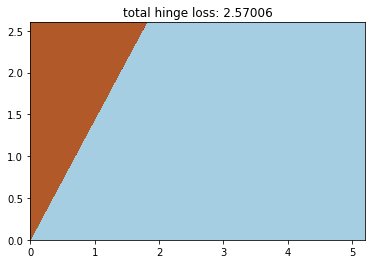

In [62]:
"""
Print the minimum loss
Plot and display the progression of loss. Use provided plotting functions
"""

#begin_solution
def plot_test(x,y,w):
    plt.figure()
    x1, x2 = x[:,0], x[:,1]
    x1_min, x1_max = np.min(x1)*.7, np.max(x1)*1.3
    x2_min, x2_max = np.min(x2)*.7, np.max(x2)*1.3
    gridpoints = 2000
    x1s = np.linspace(x1_min, x1_max, gridpoints)
    x2s = np.linspace(x2_min, x2_max, gridpoints)
    gridx1, gridx2 = np.meshgrid(x1s,x2s)
    grid_pts = np.c_[gridx1.ravel(), gridx2.ravel()]
    predictions = np.array([np.sign(np.dot(w,x_)) for x_ in grid_pts]).reshape((gridpoints,gridpoints))
    plt.contourf(gridx1, gridx2, predictions, cmap=plt.cm.Paired)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
    plt.title('total hinge loss: %g' % hinge_loss(w,x,y)[0])
    plt.show()
if __name__ == '__main__':
    np.set_printoptions(precision=3)
    test1()

#end_solution



**Question 5.c**
<a name='question5c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [50]:
class SVM:
  def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
    self.kernel = {'poly':lambda x,y: np.dot(x, y.T)**degree,
                   'rbf':lambda x,y:np.exp(-gamma*np.sum((y-x[:,np.newaxis])**2,axis=-1)),
                   'linear':lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter

  def restrict_to_square(self, t, v0, u):
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
    self.X = X.copy()
    self.y = y * 2 - 1
    self.lambdas = np.zeros_like(self.y, dtype=float)
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y

    for _ in range(self.max_iter):
      for idxM in range(len(self.lambdas)):
        idxL = np.random.randint(0, len(self.lambdas))
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
        v0 = self.lambdas[[idxM, idxL]]
        k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
        u = np.array([-self.y[idxL], self.y[idxM]])
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
        self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)

    idx, = np.nonzero(self.lambdas > 1E-15)
    self.b = np.sum((1.0-np.sum(self.K[idx]*self.lambdas, axis=1))*self.y[idx])/len(idx)

  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

In [51]:
X_iris_svm = np.copy(X_iris)
Y_iris_svm = np.copy(Y_iris)
Y_iris_svm[Y_iris==0] = -1
Y_iris_svm[Y_iris!=0] = 1

Y_iris_test_svm = np.copy(Y_iris_test)
Y_iris_test_svm[Y_iris_test==0] = -1
Y_iris_test_svm[Y_iris_test!=0] = 1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [53]:
def gaussianKernel(X1, X2, sigma):
    #begin_solution
    """
    Returns a gaussian kernel between X1 and X2
    and returns the similarity matrix in sim.
    Define the kernel by either giving the kernel
    as a python function or by precomputing the Gram
    matrix.
    Args:
        X1: array
        X2: array
        sigma: float, the bandwidth parameter
    Returns:
        Gram: array
    """
    Gram = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            x1 = x1.ravel()
            x2 = x2.ravel()
            Gram[i, j] = np.exp(-np.sum(np.square(x1 - x2)) / (2 * (sigma**2)))
    print(Gram)
    return Gram
 

"""
After implementing ksvm and kernel, test it below on the IRIS dataset.
Print the accuracy of the model.
"""



#end_solution


'\nAfter implementing ksvm and kernel, test it below on the IRIS dataset.\nPrint the accuracy of the model.\n'

In [59]:
#begin_test
def accuracy(y, y_iris_svm):
            return np.sum(y==Y)/len(Y)
train_preds = predict(X,X_iris_test)
accuracy(X, train_pred)
#end_test


TypeError: predict() missing 1 required positional argument: 'X'

## 6. Neural Networks (20 points)
<a name='question6'></a>

[a)](#question6a) Devise a three-layer neural network with n hidden states and sigmoid activations for classification. Explain how many parameters this has in one sentence. (**2 points**)

[b)](#question6b) Implement the binary classifier nnclass(examplesA, examples, testExamples) that is trained with your implementation of (stochastic) GD and your gradient function using the network. (**5 points** + **7 points** on hidden dataset)

[c)](#question6c) Do an analysis how changes affect the accuracy with _MNIST_. Positive labels are assigned to digit 1 and negative samples to other digits. Write no longer than fifteen sentences. A table and / or plot is welcome. (**6 points**)

**Question 6.a**
<a name='question6a'></a>

_Your reply:_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

**Question 6.b**
<a name='question6b'></a>

In [ ]:
def sigmoid(z):
    """
    Write your activation function here.

    Arguments:
    z : Scalar or batch of scalars on which to compute activation(s)

    Returns:
    activation : The activation value(s)
    """

    #begin_solution

    #end_solution


    return activation

def dsigmoid(z):
    """
    Implement the gradient of the activation function.

    Arguments:
    z : Scalar or batch of scalars

    Returns:
    gradient : Gradient(s) of the activation function
    """

    #begin_solution

    #end_solution


    return gradient

In [ ]:
#begin_test

#end_test


Implementation of the forward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def forward_pass(x, W, b):
    """
    Write your implementation of forward pass here.

    Arguments:
    x : Input data matrix
    W : Tuple of weight matrices
    b : Tuple of biases

    Returns:
    y_hat : Output of last layer
    cache : A tuple, that contains all intermediate outputs. These will be
            needed in your backward pass. Save anything in cache that you
            plan to use in the backward pass. It should be a tuple
    """

    #begin_solution

    #end_solution


    return y_hat, cache

#begin_test

#end_test


Implementation of the loss and its associated gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def loss(preds, targets):
    """
    Write your loss function here.

    Arguments:
    preds: The network predictions
    targets: The true labels

    Returns:
    cost: An error metric between pred and targets
    """

    #begin_solution

    #end_solution

    
    return cost

def dloss(preds, target):
    """
    Write the derivative of loss function here.

    Arguments:
    preds : The network predictions
    target : The true labels

    Returns:
    gradient : The derivative of loss function with respect to the
              network outputs
    """

    #begin_solution

    #end_solution


    return gradient

In [ ]:
#begin_test

#end_test


Implementation of the backward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def backward_pass(preds, targets, W, b, X, cache):
    """
    Write your implementation of backward_pass here.

    Arguments:
    preds : The network predictions
    targets : The true labels
    W : A tuple of weight matrices
    b : A tuple of bias values
    X : Input data matrix
    cache : Tuple of Intermediate outputs that you cached in forward_pass

    Returns:
    Gradients with respect to each layer's weights and biases
    """
    
    #begin_solution

    #end_solution

    
    return J_w3, J_w2, J_w1, J_b3, J_b2, J_b1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def training(X, Y, W, b, step_size, max_it):
    """
    Implement your training loop here.

    Arguments:
    X : Input Data matrix
    Y : True labels
    W : A tuple of weight matrices
    step_size : The step size to take for network updates
    max_it : The maximum iterations after which to stop

    Returns:
    W : The trained weights
    b : The trained biases
    history : A list of your loss values at each iteration
    """
    
    #begin_test

    #end_test

    
    #begin_solution

    #end_solution

    
    #begin_test

    #end_test

            
    return W, b, history

In [ ]:
#begin_test

#end_test


In [ ]:
"""
Below, initialize the weights and biases randomly.
Start your training loop with your choice of parameters step_size, max_it
"""

#begin_solution

#end_solution




**Question 6.c**
<a name='question6d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

In [ ]:
#begin_test

#end_test
